In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git
! pip install pdbpp
! pip install pycocoevalcap
! pip install PyDictionary
! pip install nltk==3.6.5
! pip inSstall torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-i3mrrisy
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-i3mrrisy
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369398 sha256=203fa91e8fcc1a07bf3f596975cec9c5da220c8b46dbcb6ec77d20913c3580c4
  Stored in directory: /tmp/pip-ephem-wheel-cache-9hqij8t1/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/sim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 6.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1270 sha256=339de4df77968e5b0e1dde6fd3255e5d25f42505fb3c58d31e927447096a23a2
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
  Created wheel for goslate: filename=goslate-1.5.4-py3-none-any.whl size=11594 sha256=f17d2fd4b581b104de4cb7d3e19c727b8ef7019907c4818be273659f0fab898a
  Stored in directory: /root/.cache/pip/wheels/b5/30/e9/63b6de83667be2977ee793a146a2c80f8e588d5c0203b39dc9
  Created wheel for futures: filename=futures-3.0.5-py3-none-any.whl size=14087 sha256=1a

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.5 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.8.1
    Uninstalling nltk-3.8.1:
      Successfully uninstalled nltk-3.8.1
ERROR: unknown command "inSstall" - maybe you meant "install"


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode
openjdk version "1.8.0_362"
OpenJDK Runtime Environment (build 1.8.0_362-8u362-ga-0ubuntu1~20.04.1-b09)
OpenJDK 64-Bit Server VM (build 25.362-b09, mixed mode)


In [ ]:
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice

from google.colab import drive
drive.mount('/content/gdrive')

import nltk
nltk.download('punkt')
nltk.download('wordnet')

from nltk.translate import meteor_score
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
import numpy as np
import torch
from PIL import Image
import pandas as pd
import random
import copy
import os
from tqdm import tqdm

Mounted at /content/gdrive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
f = open(os.path.relpath('gdrive/Shareddrives/CS2952N/Flickr8k_text/Flickr_8k.trainImages.txt'), 'r')

train_image_filenames = set()

for line in tqdm(f.readlines()):
  
  train_image_filenames.add(line[:-1])

100%|██████████| 6000/6000 [00:00<00:00, 800872.74it/s]


In [ ]:
f = open(os.path.relpath('gdrive/Shareddrives/CS2952N/Flickr8k_text/Flickr8k.token.txt'), 'r')

caption_dictionary = {}

for line in tqdm(f.readlines()):

  if line[:line.index('#')] not in train_image_filenames:
    continue

  if line[:line.index('#')] not in caption_dictionary:
    caption_dictionary[line[:line.index('#')]] = [line[line.index('#')+3:].strip().lower()]
  else:
    caption_dictionary[line[:line.index('#')]].append(line[line.index('#')+3:].strip().lower())

100%|██████████| 40460/40460 [00:00<00:00, 531948.07it/s]


In [ ]:
subset = list(random.sample(train_image_filenames, 1000))

annotation_dataset = pd.DataFrame(columns=['image_filename','caption_file', 'caption_no','caption','rating'])



for i in range(len(subset)):

  print('Processing image {} of {}'.format(i+1, len(subset)))

  for j in range(len(subset)):

    if i==j:
      continue
    
    c = caption_dictionary[subset[j]][2]
    row = [subset[i], subset[j], 2, c, None]

    annotation_dataset.loc[len(annotation_dataset.index)] = row
  
  if i%50==0:
    annotation_dataset.to_csv('gdrive/Shareddrives/CS2952N/human_evaluated_captions.csv',index=False)

annotation_dataset.to_csv('gdrive/Shareddrives/CS2952N/human_evaluated_captions.csv',index=False)


<ipython-input-14-426a3ede6436>:1: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  subset = list(random.sample(train_image_filenames, 1000))


Processing image 1 of 1000
Processing image 2 of 1000
Processing image 3 of 1000
Processing image 4 of 1000
Processing image 5 of 1000
Processing image 6 of 1000
Processing image 7 of 1000
Processing image 8 of 1000
Processing image 9 of 1000
Processing image 10 of 1000
Processing image 11 of 1000
Processing image 12 of 1000
Processing image 13 of 1000
Processing image 14 of 1000
Processing image 15 of 1000
Processing image 16 of 1000
Processing image 17 of 1000
Processing image 18 of 1000
Processing image 19 of 1000
Processing image 20 of 1000
Processing image 21 of 1000
Processing image 22 of 1000
Processing image 23 of 1000
Processing image 24 of 1000
Processing image 25 of 1000
Processing image 26 of 1000
Processing image 27 of 1000
Processing image 28 of 1000
Processing image 29 of 1000
Processing image 30 of 1000
Processing image 31 of 1000
Processing image 32 of 1000
Processing image 33 of 1000
Processing image 34 of 1000
Processing image 35 of 1000
Processing image 36 of 1000
P

In [ ]:
import clip

# RN50 will be fastest, while ViT-L will be the most performant.
clip.available_models()


clip_backbones = {'ResNet50': "RN50", 'ResNet101': "RN50x16", 'ViTL': 'ViT-L/14', 'ViTB': "ViT-B/16", 'ViTB32': 'ViT-B/32'}

chosen_model = 'ViTL'

clip_model, preprocessor = clip.load(clip_backbones[chosen_model])
clip_model.cuda().eval()

input_resolution = clip_model.visual.input_resolution
context_length = clip_model.context_length
vocab_size = clip_model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|████████████████████████████████████████| 890M/890M [00:06<00:00, 134MiB/s]


Model parameters: 427,616,513
Input resolution: 224
Context length: 77
Vocab size: 49408


In [ ]:
cider_metric = Cider()
spice_metric = Spice()

Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.


In [ ]:
def get_weights(max_n=1):

  if max_n==1:
    weights = (1, 0, 0, 0)
  elif max_n == 2:
    weights = (0.5, 0.5, 0, 0)
  elif max_n == 3:
    weights = (0.33, 0.33, 0.33, 0)
  else:
    weights = (0.25, 0.25, 0.25, 0.25)

  return weights 

def compute_all_bleu_scores(caption_dictionary, experiment='test'):
  
  
  bleu_df = pd.DataFrame(columns=['ref','hypoth','n','bleu_score'])
  avg_bleu_scores = []

  references = []
  hypotheses = []

  for k in caption_dictionary.keys():

    if k not in train_image_filenames:
      continue

    gt_captions = caption_dictionary[k]

    for i in range(len(gt_captions)):

      hypotheses.append(gt_captions[i].split(' '))

      ref_for_i = []

      for j in range(len(gt_captions)):

        if i==j:
          continue


        ref_for_i.append(gt_captions[j].split(' '))
      
      references.append(ref_for_i)

  
  for n in range(1,5):
   
    weights = get_weights(n)


    for ref,hyp in zip(references[::20], hypotheses[::20]):
      bleu_score = sentence_bleu(ref, hyp, weights=weights)

      
      bleu_df = bleu_df.append({'ref': ';'.join([' '.join(r) for r in ref]), 'hypoth': hyp, 'n': n, 'bleu_score': bleu_score}, ignore_index=True)


    corp_bleu = corpus_bleu(references, hypotheses, weights = weights)
    avg_bleu_scores.append(corp_bleu)
  

 
  bleu_df.to_csv('gdrive/Shareddrives/CS2952N/bleu_scores_{}.csv'.format(experiment))
  
  return avg_bleu_scores 

def compute_meteor_score(gt_captions, pred_caption):
  """
  pred_caption: string containing predicted caption
  gt_caption: string containing ground-truth caption
  """

  return max([meteor_score.single_meteor_score(word_tokenize(gt), word_tokenize(pred_caption)) for gt in gt_captions])



def compute_all_meteor_scores(caption_dictionary, experiment='test'):
  
  meteor_df = pd.DataFrame(columns=['ref','hypoth','meteor_score'])

  avg_meteor = 0
  count = 0

  for m,k in enumerate(caption_dictionary.keys()):

    if k not in train_image_filenames:
      continue
    
    gt_captions = caption_dictionary[k]

    for i in range(len(gt_captions)):

      refs = []
      
      for j,c in enumerate(gt_captions):
        if j==i:
          continue
        refs.append(c)

      score = compute_meteor_score(refs, gt_captions[i])

      if (m*len(gt_captions) + i)%20 == 0:
        meteor_df = meteor_df.append({'ref': ';'.join(refs), 'hypoth': gt_captions[i],  'meteor_score': score}, ignore_index=True)

      avg_meteor += score
      count += 1

  meteor_df.to_csv('gdrive/Shareddrives/CS2952N/meteor_scores_{}.csv'.format(experiment))
  
  return avg_meteor/count



def compute_all_spice_scores(caption_dictionary, experiment='test'):
  
  spice_df = pd.DataFrame(columns=['ref','hypoth','spice_score'])
  references = {}
  hypotheses = {}
  img_counts = {}

  for k in caption_dictionary.keys():

    if k not in train_image_filenames:
      continue

    gt_captions = caption_dictionary[k]

    for i in range(len(gt_captions)):

      if k not in img_counts:
        img_counts[k] = 0
      
      img_counts[k] += 1

      hypotheses[k+'_'+str(img_counts[k])] = [gt_captions[i]]

      ref_for_i = []

      for j in range(len(gt_captions)):

        if i==j:
          continue


        ref_for_i.append(gt_captions[j])
      
      references[k+'_'+str(img_counts[k])] = ref_for_i
  

  
  
  avg_score, scores = spice_metric.compute_score(references, hypotheses)


  for i,k in enumerate(hypotheses.keys()):
    if i%20 == 0:
      spice_df = spice_df.append({'ref': references[k] , 'hypoth': hypotheses[k], 'spice_score': scores[i]}, ignore_index=True)
  
  spice_df.to_csv('gdrive/Shareddrives/CS2952N/spice_scores_{}.csv'.format(experiment))
  return avg_score


def compute_all_cider_scores(caption_dictionary, experiment='test'):
  
  cider_df = pd.DataFrame(columns=['ref','hypoth','spice_score'])
  references = {}
  hypotheses = {}
  img_counts = {}

  for k in caption_dictionary.keys():

    if k not in train_image_filenames:
      continue

    gt_captions = caption_dictionary[k]

    for i in range(len(gt_captions)):

      if k not in img_counts:
        img_counts[k] = 0
      
      img_counts[k] += 1

      hypotheses[k+'_'+str(img_counts[k])] = [gt_captions[i]]

      ref_for_i = []

      for j in range(len(gt_captions)):

        if i==j:
          continue


        ref_for_i.append(gt_captions[j])
      
      references[k+'_'+str(img_counts[k])] = ref_for_i
  

  
  
  avg_score, scores = cider_metric.compute_score(references, hypotheses)


  for i,k in enumerate(hypotheses.keys()):
    if i%20 == 0:
      cider_df = cider_df.append({'ref': references[k] , 'hypoth': hypotheses[k], 'spice_score': scores[i]}, ignore_index=True)
  
  cider_df.to_csv('gdrive/Shareddrives/CS2952N/cider_scores_{}.csv'.format(experiment))
  return avg_score




In [ ]:
def compute_all_clip_scores(image_dataloader, model, experiment='test'):
  average_clip_score = 0

  cosine_sim = torch.nn.CosineSimilarity(dim=1)

  clip_df = pd.DataFrame(columns=['image_file','ref','clip_score'])

  for idx, (image_filenames, image_features, captions, text_features) in enumerate(image_dataloader):
    
    
    print('Processing image {} of {}'.format(idx+1, len(image_dataloader)))
    

    image_features = image_features.repeat(1, text_features.shape[1], 1)  

    image_features = torch.reshape(image_features, (image_features.shape[0]*image_features.shape[1], image_features.shape[2]))
    text_features = torch.reshape(text_features, (text_features.shape[0]*text_features.shape[1], text_features.shape[2]))
    
    
    cos_sim = cosine_sim(text_features, image_features)
    cos_sim[cos_sim<0] = 0

    clip_scores = 2.5*cos_sim


    # extract all values (for a batch) that are to be added to pandas df
    clip_scores = clip_scores.cpu().numpy()
    
    captions_per_image = np.array(captions).shape[0]
    
    refs = np.transpose(np.array(captions)).flatten()
    
    image_filenames = np.repeat(np.array(image_filenames), captions_per_image) 



    batch_df = pd.DataFrame.from_dict({'image_file': image_filenames, 'ref': refs, 'clip_score': clip_scores},orient='index').transpose()

    clip_df = clip_df.append(batch_df, ignore_index=True)

    average_clip_score += np.sum(clip_scores)


  clip_df.to_csv('gdrive/Shareddrives/CS2952N/clip_scores_{}.csv'.format(experiment))
  return average_clip_score/(len(image_dataloader)*250)

In [ ]:
def compute_all_clip_scores1(image_dataloader, model, experiment='test'):
  average_clip_score = 0

  

  cosine_sim = torch.nn.CosineSimilarity(dim=1)

  clip_df = pd.DataFrame(columns=['image_file','ref','clip_score'])

  for idx, (image_filenames, image_features, captions) in enumerate(image_dataloader):
    
    
    print('Processing image {} of {}'.format(idx+1, len(image_dataloader)))
    
    refs = np.transpose(np.array(captions)).flatten()
    captions_per_image = np.array(captions).shape[0]


    text_tokens = clip.tokenize(refs).cuda()

    with torch.no_grad():
      text_features = model.encode_text(text_tokens).float()
      text_features /= text_features.norm(dim=-1, keepdim=True)

    image_features = image_features.repeat(1, captions_per_image, 1)  

    image_features = torch.reshape(image_features, (image_features.shape[0]*image_features.shape[1], image_features.shape[2]))
    
    
    
    cos_sim = cosine_sim(text_features, image_features)
    cos_sim[cos_sim<0] = 0

    clip_scores = 2.5*cos_sim


    # extract all values (for a batch) that are to be added to pandas df
    clip_scores = clip_scores.cpu().numpy()
    
    
    
    image_filenames = np.repeat(np.array(image_filenames), captions_per_image) 



    batch_df = pd.DataFrame.from_dict({'image_file': image_filenames, 'ref': refs, 'clip_score': clip_scores},orient='index').transpose()

    clip_df = clip_df.append(batch_df, ignore_index=True)

    average_clip_score += np.sum(clip_scores)


  clip_df.to_csv('gdrive/Shareddrives/CS2952N/clip_scores_{}.csv'.format(experiment), index=False)
  return average_clip_score/(1000*5)

In [ ]:
f = open(os.path.relpath('gdrive/Shareddrives/CS2952N/Flickr8k_text/Flickr_8k.testImages.txt'), 'r')

train_image_filenames = set()

for line in tqdm(f.readlines()):
  
  train_image_filenames.add(line[:-1])




print('Test Set Length: {} \n'.format(len(train_image_filenames)))

100%|██████████| 1000/1000 [00:00<00:00, 70855.71it/s]

Test Set Length: 1000 



In [ ]:
f = open(os.path.relpath('gdrive/Shareddrives/CS2952N/Flickr8k_text/Flickr8k.token.txt'), 'r')

caption_dictionary = {}

for line in tqdm(f.readlines()):

  if line[:line.index('#')] not in train_image_filenames:
    continue

  if line[:line.index('#')] not in caption_dictionary:
    caption_dictionary[line[:line.index('#')]] = [line[line.index('#')+3:].strip().lower()]
  else:
    caption_dictionary[line[:line.index('#')]].append(line[line.index('#')+3:].strip().lower())

100%|██████████| 40460/40460 [00:00<00:00, 350617.22it/s]


In [ ]:
class FlickrDataset(torch.utils.data.Dataset):

  def __init__(self, train_image_filenames, caption_dictionary, clip_model, image_preprocessor):

    self.BASE_PATH = 'gdrive/Shareddrives/CS2952N/Flicker8k_Dataset'

    self.image_filenames = train_image_filenames
    self.caption_dict = caption_dictionary
    self.clip_model = clip_model
    self.image_preprocessor = image_preprocessor
  
  def image_load_preprocess_embed(self, filename):

    image = Image.open(os.path.join(self.BASE_PATH, filename)).convert("RGB")
    image = self.image_preprocessor(image)

    
    image = torch.unsqueeze(image, dim=0).cuda()

    with torch.no_grad():
      image_embedding = self.clip_model.encode_image(image).float()
    image_embedding /= image_embedding.norm(dim=-1, keepdim=True)
    return image_embedding
  
  def __len__(self):
    return len(self.image_filenames)
  
  def __getitem__(self, index):
    
    image_features = self.image_load_preprocess_embed(self.image_filenames[index])
    captions = ['A photo depicts ' + c for c in self.caption_dict[self.image_filenames[index]]]
    
   
    

    return self.image_filenames[index], image_features, captions

#CLIP Scores

In [ ]:
dataset = FlickrDataset(list(train_image_filenames), caption_dictionary, clip_model, preprocessor)
image_dataloader = torch.utils.data.DataLoader(dataset, batch_size=50)

avg_clip_scores = compute_all_clip_scores1(image_dataloader, clip_model, experiment='flickr8k')
print(avg_clip_scores)

Processing image 1 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 2 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 3 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 4 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 5 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 6 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 7 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 8 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 9 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 10 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 11 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 12 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 13 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 14 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 15 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 16 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 17 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 18 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 19 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 20 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 21 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 22 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 23 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 24 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 25 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 26 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 27 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 28 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 29 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 30 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 31 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 32 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 33 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 34 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 35 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 36 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 37 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 38 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 39 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 40 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 41 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 42 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 43 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 44 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 45 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 46 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 47 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 48 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 49 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 50 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 51 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 52 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 53 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 54 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 55 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 56 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 57 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 58 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 59 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 60 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 61 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 62 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 63 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 64 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 65 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 66 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 67 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 68 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 69 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 70 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 71 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 72 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 73 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 74 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 75 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 76 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 77 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 78 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 79 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 80 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 81 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 82 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 83 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 84 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 85 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 86 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 87 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 88 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 89 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 90 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 91 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 92 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 93 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 94 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 95 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 96 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 97 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 98 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 99 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 100 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 101 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 102 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 103 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 104 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 105 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 106 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 107 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 108 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 109 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 110 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 111 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 112 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 113 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 114 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 115 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 116 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 117 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 118 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 119 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 120 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


0.7141115203857422


In [ ]:
percent_shuffled_captions = 0.90

examples_to_skew = random.sample(list(caption_dictionary.keys()), k=int(len(caption_dictionary.keys())*percent_shuffled_captions))

caption_dict_shuffled = copy.deepcopy(caption_dictionary)

for f in examples_to_skew:
  caption_dict_shuffled[f] = [ ' '.join(random.sample( c.split(' '), len(c.split(' ')) )) for c in caption_dict_shuffled[f]]


dataset = FlickrDataset(list(train_image_filenames), caption_dict_shuffled, clip_model, preprocessor)
image_dataloader = torch.utils.data.DataLoader(dataset, batch_size=50)

avg_clip_scores = compute_all_clip_scores1(image_dataloader, clip_model, experiment='flickr8k_shuffled_{}'.format( int(percent_shuffled_captions*100)))
print(avg_clip_scores)

Processing image 1 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 2 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 3 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 4 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 5 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 6 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 7 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 8 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 9 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 10 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 11 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 12 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 13 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 14 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 15 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 16 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 17 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 18 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 19 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 20 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 21 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 22 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 23 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 24 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 25 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 26 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 27 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 28 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 29 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 30 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 31 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 32 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 33 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 34 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 35 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 36 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 37 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 38 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 39 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 40 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 41 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 42 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 43 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 44 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 45 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 46 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 47 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 48 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 49 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 50 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 51 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 52 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 53 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 54 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 55 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 56 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 57 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 58 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 59 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 60 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 61 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 62 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 63 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 64 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 65 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 66 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 67 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 68 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 69 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 70 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 71 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 72 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 73 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 74 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 75 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 76 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 77 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 78 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 79 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 80 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 81 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 82 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 83 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 84 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 85 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 86 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 87 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 88 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 89 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 90 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 91 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 92 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 93 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 94 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 95 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 96 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 97 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 98 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 99 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 100 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 101 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 102 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 103 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 104 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 105 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 106 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 107 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 108 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 109 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 110 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 111 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 112 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 113 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 114 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 115 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 116 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 117 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 118 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 119 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 120 of 120


<ipython-input-5-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


0.6383876134236653


In [ ]:
percent_swapped_captions = 0.90

examples_to_skew = random.sample(list(caption_dictionary.keys()), k=int(len(caption_dictionary.keys())*percent_swapped_captions))

swapped_captions = []
for e in examples_to_skew:
  swapped_captions += caption_dictionary[e]

random.shuffle(swapped_captions)
swapped_captions = [swapped_captions[n:n+5] for n in range(0, len(swapped_captions), 5)]

#make copy of caption dictionary
caption_dict_swapped = copy.deepcopy(caption_dictionary)


for i, e in enumerate(examples_to_skew):
  
  caption_dict_swapped[e] = swapped_captions[i]


dataset = FlickrDataset(list(train_image_filenames), caption_dict_swapped, clip_model, preprocessor)
image_dataloader = torch.utils.data.DataLoader(dataset, batch_size=50)

avg_clip_scores = compute_all_clip_scores1(image_dataloader, clip_model, experiment='flickr8k_other_images_{}'.format( int(percent_swapped_captions*100)))
print(avg_clip_scores)

Processing image 1 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 2 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 3 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 4 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 5 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 6 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 7 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 8 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 9 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 10 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 11 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 12 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 13 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 14 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 15 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 16 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 17 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 18 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 19 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 20 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 21 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 22 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 23 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 24 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 25 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 26 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 27 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 28 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 29 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 30 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 31 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 32 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 33 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 34 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 35 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 36 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 37 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 38 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 39 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 40 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 41 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 42 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 43 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 44 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 45 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 46 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 47 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 48 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 49 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 50 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 51 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 52 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 53 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 54 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 55 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 56 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 57 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 58 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 59 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 60 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 61 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 62 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 63 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 64 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 65 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 66 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 67 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 68 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 69 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 70 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 71 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 72 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 73 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 74 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 75 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 76 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 77 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 78 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 79 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 80 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 81 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 82 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 83 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 84 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 85 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 86 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 87 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 88 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 89 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 90 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 91 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 92 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 93 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 94 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 95 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 96 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 97 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 98 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 99 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 100 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 101 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 102 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 103 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 104 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 105 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 106 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 107 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 108 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 109 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 110 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 111 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 112 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 113 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 114 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 115 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 116 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 117 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 118 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 119 of 120


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


Processing image 120 of 120
0.4649219886779785


<ipython-input-15-ec546304333b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(batch_df, ignore_index=True)


#EVALUATING BLEU SCORES

In [ ]:
avg_bleu_scores = compute_all_bleu_scores(caption_dictionary, experiment='flickr8k')
print(avg_bleu_scores)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
<ipython-input-5-3d6706c53fb4>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bleu_df = bleu_df.append({'ref': ';'.join([' '.join(r) for r in ref]), 'hypoth': hyp, 'n': n, 'bleu_score': bleu_score}, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFu

[0.6709757004292135, 0.4685803061203026, 0.32628362455391496, 0.2217085491993993]


In [ ]:
percent_shuffled_captions = 0.20

examples_to_skew = random.sample(list(caption_dictionary.keys()), k=int(len(caption_dictionary.keys())*percent_shuffled_captions))


caption_dict_shuffled = copy.deepcopy(caption_dictionary)


for f in examples_to_skew:
  caption_dict_shuffled[f] = [ ' '.join(random.sample( c.split(' '), len(c.split(' ')) )) for c in caption_dict_shuffled[f]]

avg_bleu_scores = compute_all_bleu_scores(caption_dict_shuffled, experiment='flickr8k_shuffled_{}'.format( int(percent_shuffled_captions*100)  ))
print(avg_bleu_scores)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
<ipython-input-5-3d6706c53fb4>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bleu_df = bleu_df.append({'ref': ';'.join([' '.join(r) for r in ref]), 'hypoth': hyp, 'n': n, 'bleu_score': b

[0.6709757004292135, 0.43620843669035925, 0.291649718469668, 0.19406881342184193]


In [ ]:
percent_swapped_captions = 0.20

examples_to_skew = random.sample(list(caption_dictionary.keys()), k=int(len(caption_dictionary.keys())*percent_swapped_captions))

swapped_captions = []
for e in examples_to_skew:
  swapped_captions += caption_dictionary[e]

# shuffle and group captions for chosen examples
random.shuffle(swapped_captions)
swapped_captions = [swapped_captions[n:n+5] for n in range(0, len(swapped_captions), 5)]

#make copy of caption dictionary
caption_dict_swapped = copy.deepcopy(caption_dictionary)


for i, e in enumerate(examples_to_skew):
  
  caption_dict_swapped[e] = swapped_captions[i]



avg_bleu_scores = compute_all_bleu_scores(caption_dict_swapped, experiment='flickr8k_other_images_{}'.format( int(percent_swapped_captions*100) ) )
print(avg_bleu_scores)

Streaming output truncated to the last 5000 lines.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
<ipython-input-5-3d6706c53fb4>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bleu_df = bleu_df.append({'ref': ';'.join([' '.join(r) for r in ref]), 'hypoth': hyp, 'n': n, 'bleu_score': bleu_score}, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contain

[0.6134205278988814, 0.4068009284420778, 0.2764354118288913, 0.18416233733109622]


#METEOR Score

In [ ]:
avg_meteor_scores = compute_all_meteor_scores(caption_dictionary, experiment='flickr8k')
print(avg_meteor_scores)

<ipython-input-5-3d6706c53fb4>:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  meteor_df = meteor_df.append({'ref': ';'.join(refs), 'hypoth': gt_captions[i],  'meteor_score': score}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  meteor_df = meteor_df.append({'ref': ';'.join(refs), 'hypoth': gt_captions[i],  'meteor_score': score}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  meteor_df = meteor_df.append({'ref': ';'.join(refs), 'hypoth': gt_captions[i],  'meteor_score': score}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:104: FutureWarning: The frame.append method is deprecated and will be removed from pand

0.5012768073194764


<ipython-input-5-3d6706c53fb4>:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  meteor_df = meteor_df.append({'ref': ';'.join(refs), 'hypoth': gt_captions[i],  'meteor_score': score}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  meteor_df = meteor_df.append({'ref': ';'.join(refs), 'hypoth': gt_captions[i],  'meteor_score': score}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  meteor_df = meteor_df.append({'ref': ';'.join(refs), 'hypoth': gt_captions[i],  'meteor_score': score}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:104: FutureWarning: The frame.append method is deprecated and will be removed from pand

In [ ]:
percent_shuffled_captions = 0.20

examples_to_skew = random.sample(list(caption_dictionary.keys()), k=int(len(caption_dictionary.keys())*percent_shuffled_captions))


caption_dict_shuffled = copy.deepcopy(caption_dictionary)


for f in examples_to_skew:
  caption_dict_shuffled[f] = [ ' '.join(random.sample( c.split(' '), len(c.split(' ')) )) for c in caption_dict_shuffled[f]]


avg_meteor_scores = compute_all_meteor_scores(caption_dict_shuffled, experiment='flickr8k_shuffled_{}'.format( int(percent_shuffled_captions*100))  )
print(avg_meteor_scores)

<ipython-input-5-3d6706c53fb4>:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  meteor_df = meteor_df.append({'ref': ';'.join(refs), 'hypoth': gt_captions[i],  'meteor_score': score}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  meteor_df = meteor_df.append({'ref': ';'.join(refs), 'hypoth': gt_captions[i],  'meteor_score': score}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  meteor_df = meteor_df.append({'ref': ';'.join(refs), 'hypoth': gt_captions[i],  'meteor_score': score}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:104: FutureWarning: The frame.append method is deprecated and will be removed from pand

0.47414324953977555


<ipython-input-5-3d6706c53fb4>:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  meteor_df = meteor_df.append({'ref': ';'.join(refs), 'hypoth': gt_captions[i],  'meteor_score': score}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  meteor_df = meteor_df.append({'ref': ';'.join(refs), 'hypoth': gt_captions[i],  'meteor_score': score}, ignore_index=True)


In [ ]:
percent_swapped_captions = 0.20

examples_to_skew = random.sample(list(caption_dictionary.keys()), k=int(len(caption_dictionary.keys())*percent_swapped_captions))

swapped_captions = []
for e in examples_to_skew:
  swapped_captions += caption_dictionary[e]

random.shuffle(swapped_captions)
swapped_captions = [swapped_captions[n:n+5] for n in range(0, len(swapped_captions), 5)]

#make copy of caption dictionary
caption_dict_swapped = copy.deepcopy(caption_dictionary)


for i, e in enumerate(examples_to_skew):
  
  caption_dict_swapped[e] = swapped_captions[i]


avg_meteor_scores = compute_all_meteor_scores(caption_dict_swapped, experiment='flickr8k_other_images_{}'.format( int(percent_swapped_captions*100) ) )
print(avg_meteor_scores)

<ipython-input-5-3d6706c53fb4>:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  meteor_df = meteor_df.append({'ref': ';'.join(refs), 'hypoth': gt_captions[i],  'meteor_score': score}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  meteor_df = meteor_df.append({'ref': ';'.join(refs), 'hypoth': gt_captions[i],  'meteor_score': score}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  meteor_df = meteor_df.append({'ref': ';'.join(refs), 'hypoth': gt_captions[i],  'meteor_score': score}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:104: FutureWarning: The frame.append method is deprecated and will be removed from pand

0.4463525226868007


<ipython-input-5-3d6706c53fb4>:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  meteor_df = meteor_df.append({'ref': ';'.join(refs), 'hypoth': gt_captions[i],  'meteor_score': score}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  meteor_df = meteor_df.append({'ref': ';'.join(refs), 'hypoth': gt_captions[i],  'meteor_score': score}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  meteor_df = meteor_df.append({'ref': ';'.join(refs), 'hypoth': gt_captions[i],  'meteor_score': score}, ignore_index=True)


#SPICE Score

In [ ]:
avg_spice_scores = compute_all_spice_scores(caption_dictionary, experiment='flickr8k')
print(avg_spice_scores)

<ipython-input-5-3d6706c53fb4>:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spice_df = spice_df.append({'ref': references[k] , 'hypoth': hypotheses[k], 'spice_score': scores[i]}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spice_df = spice_df.append({'ref': references[k] , 'hypoth': hypotheses[k], 'spice_score': scores[i]}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spice_df = spice_df.append({'ref': references[k] , 'hypoth': hypotheses[k], 'spice_score': scores[i]}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

0.2305360597108907


<ipython-input-5-3d6706c53fb4>:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spice_df = spice_df.append({'ref': references[k] , 'hypoth': hypotheses[k], 'spice_score': scores[i]}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spice_df = spice_df.append({'ref': references[k] , 'hypoth': hypotheses[k], 'spice_score': scores[i]}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spice_df = spice_df.append({'ref': references[k] , 'hypoth': hypotheses[k], 'spice_score': scores[i]}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

In [ ]:
print(avg_spice_scores)

0.2305360597108907


In [ ]:
percent_shuffled_captions = 0.20

examples_to_skew = random.sample(list(caption_dictionary.keys()), k=int(len(caption_dictionary.keys())*percent_shuffled_captions))


caption_dict_shuffled = copy.deepcopy(caption_dictionary)


for f in examples_to_skew:
  caption_dict_shuffled[f] = [ ' '.join(random.sample( c.split(' '), len(c.split(' ')) )) for c in caption_dict_shuffled[f]]


avg_spice_scores = compute_all_spice_scores(caption_dict_shuffled, experiment='flickr8k_shuffled_{}'.format( int(percent_shuffled_captions*100))  )
print(avg_spice_scores)

<ipython-input-5-3d6706c53fb4>:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spice_df = spice_df.append({'ref': references[k] , 'hypoth': hypotheses[k], 'spice_score': scores[i]}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spice_df = spice_df.append({'ref': references[k] , 'hypoth': hypotheses[k], 'spice_score': scores[i]}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spice_df = spice_df.append({'ref': references[k] , 'hypoth': hypotheses[k], 'spice_score': scores[i]}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

0.2141769592400462


<ipython-input-5-3d6706c53fb4>:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spice_df = spice_df.append({'ref': references[k] , 'hypoth': hypotheses[k], 'spice_score': scores[i]}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spice_df = spice_df.append({'ref': references[k] , 'hypoth': hypotheses[k], 'spice_score': scores[i]}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spice_df = spice_df.append({'ref': references[k] , 'hypoth': hypotheses[k], 'spice_score': scores[i]}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

In [ ]:
print(avg_spice_scores)

0.2141769592400462


In [ ]:
percent_swapped_captions = 0.90

examples_to_skew = random.sample(list(caption_dictionary.keys()), k=int(len(caption_dictionary.keys())*percent_swapped_captions))

swapped_captions = []
for e in examples_to_skew:
  swapped_captions += caption_dictionary[e]

random.shuffle(swapped_captions)
swapped_captions = [swapped_captions[n:n+5] for n in range(0, len(swapped_captions), 5)]

#make copy of caption dictionary
caption_dict_swapped = copy.deepcopy(caption_dictionary)


for i, e in enumerate(examples_to_skew):
  
  caption_dict_swapped[e] = swapped_captions[i]


avg_spice_scores = compute_all_spice_scores(caption_dict_swapped, experiment='flickr8k_other_images_{}'.format( int(percent_swapped_captions*100) ) )
print(avg_spice_scores)

<ipython-input-4-1d4beef8bf1f>:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spice_df = spice_df.append({'ref': references[k] , 'hypoth': hypotheses[k], 'spice_score': scores[i]}, ignore_index=True)
<ipython-input-4-1d4beef8bf1f>:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spice_df = spice_df.append({'ref': references[k] , 'hypoth': hypotheses[k], 'spice_score': scores[i]}, ignore_index=True)
<ipython-input-4-1d4beef8bf1f>:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spice_df = spice_df.append({'ref': references[k] , 'hypoth': hypotheses[k], 'spice_score': scores[i]}, ignore_index=True)
<ipython-input-4-1d4beef8bf1f>:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

0.056893032204980896


<ipython-input-4-1d4beef8bf1f>:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spice_df = spice_df.append({'ref': references[k] , 'hypoth': hypotheses[k], 'spice_score': scores[i]}, ignore_index=True)
<ipython-input-4-1d4beef8bf1f>:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spice_df = spice_df.append({'ref': references[k] , 'hypoth': hypotheses[k], 'spice_score': scores[i]}, ignore_index=True)
<ipython-input-4-1d4beef8bf1f>:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spice_df = spice_df.append({'ref': references[k] , 'hypoth': hypotheses[k], 'spice_score': scores[i]}, ignore_index=True)
<ipython-input-4-1d4beef8bf1f>:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

#CIDER Score

In [ ]:
avg_cider_scores = compute_all_cider_scores(caption_dictionary, experiment='flickr8k')
print(avg_cider_scores)

<ipython-input-5-3d6706c53fb4>:207: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cider_df = cider_df.append({'ref': references[k] , 'hypoth': hypotheses[k], 'spice_score': scores[i]}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:207: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cider_df = cider_df.append({'ref': references[k] , 'hypoth': hypotheses[k], 'spice_score': scores[i]}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:207: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cider_df = cider_df.append({'ref': references[k] , 'hypoth': hypotheses[k], 'spice_score': scores[i]}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:207: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

0.8226244045373742


In [ ]:
percent_shuffled_captions = 0.20

examples_to_skew = random.sample(list(caption_dictionary.keys()), k=int(len(caption_dictionary.keys())*percent_shuffled_captions))


caption_dict_shuffled = copy.deepcopy(caption_dictionary)


for f in examples_to_skew:
  caption_dict_shuffled[f] = [ ' '.join(random.sample( c.split(' '), len(c.split(' ')) )) for c in caption_dict_shuffled[f]]


avg_cider_scores = compute_all_cider_scores(caption_dict_shuffled, experiment='flickr8k_shuffled_{}'.format( int(percent_shuffled_captions*100))  )
print(avg_cider_scores)

<ipython-input-5-3d6706c53fb4>:207: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cider_df = cider_df.append({'ref': references[k] , 'hypoth': hypotheses[k], 'spice_score': scores[i]}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:207: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cider_df = cider_df.append({'ref': references[k] , 'hypoth': hypotheses[k], 'spice_score': scores[i]}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:207: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cider_df = cider_df.append({'ref': references[k] , 'hypoth': hypotheses[k], 'spice_score': scores[i]}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:207: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

0.7718456262730351


<ipython-input-5-3d6706c53fb4>:207: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cider_df = cider_df.append({'ref': references[k] , 'hypoth': hypotheses[k], 'spice_score': scores[i]}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:207: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cider_df = cider_df.append({'ref': references[k] , 'hypoth': hypotheses[k], 'spice_score': scores[i]}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:207: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cider_df = cider_df.append({'ref': references[k] , 'hypoth': hypotheses[k], 'spice_score': scores[i]}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:207: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

In [ ]:
print(avg_cider_scores)

0.7718456262730351


In [ ]:
percent_swapped_captions = 0.20

examples_to_skew = random.sample(list(caption_dictionary.keys()), k=int(len(caption_dictionary.keys())*percent_swapped_captions))

swapped_captions = []
for e in examples_to_skew:
  swapped_captions += caption_dictionary[e]

random.shuffle(swapped_captions)
swapped_captions = [swapped_captions[n:n+5] for n in range(0, len(swapped_captions), 5)]

#make copy of caption dictionary
caption_dict_swapped = copy.deepcopy(caption_dictionary)


for i, e in enumerate(examples_to_skew):
  
  caption_dict_swapped[e] = swapped_captions[i]


avg_cider_scores = compute_all_cider_scores(caption_dict_swapped, experiment='flickr8k_other_images_{}'.format( int(percent_swapped_captions*100) ) )
print(avg_cider_scores)

<ipython-input-5-3d6706c53fb4>:207: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cider_df = cider_df.append({'ref': references[k] , 'hypoth': hypotheses[k], 'spice_score': scores[i]}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:207: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cider_df = cider_df.append({'ref': references[k] , 'hypoth': hypotheses[k], 'spice_score': scores[i]}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:207: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cider_df = cider_df.append({'ref': references[k] , 'hypoth': hypotheses[k], 'spice_score': scores[i]}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:207: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

0.6535459731256108


<ipython-input-5-3d6706c53fb4>:207: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cider_df = cider_df.append({'ref': references[k] , 'hypoth': hypotheses[k], 'spice_score': scores[i]}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:207: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cider_df = cider_df.append({'ref': references[k] , 'hypoth': hypotheses[k], 'spice_score': scores[i]}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:207: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cider_df = cider_df.append({'ref': references[k] , 'hypoth': hypotheses[k], 'spice_score': scores[i]}, ignore_index=True)
<ipython-input-5-3d6706c53fb4>:207: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

In [ ]:
avg_cider_scores

0.6535459731256108

#BoxPlot Visualization

In [1]:

from google.colab import drive
drive.mount('/content/gdrive')
import pandas as pd
from matplotlib import pyplot as plt
import random

Mounted at /content/gdrive


<ipython-input-22-8848f379b16f>:12: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  normal_pairs = set(random.sample(total_set, len(total_set)//2))


Median 0:  score       0.723996
modified    0.000000
dtype: float64
IQR 0:  score       0.1385
modified    0.0000
dtype: float64
Median 1:  score       0.716212
modified    1.000000
dtype: float64
IQR 1:  score       0.155024
modified    0.000000
dtype: float64


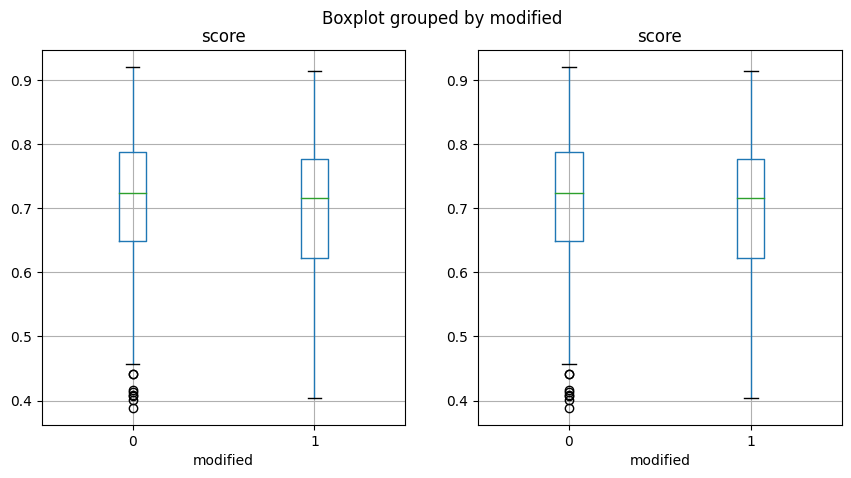

In [22]:
# get caption for every image (in order)
clip_reconstruct_normal = pd.read_csv('gdrive/Shareddrives/CS2952N/CLIP_RN50_matching.csv')
clip_reconstruct_shuffled = pd.read_csv('gdrive/Shareddrives/CS2952N/CLIP_RN50_matching_shuffled.csv')

clip_reconstruct_normal_pairs = [v.split('\t')[1]+'_'+v.split('\t')[2] for v in clip_reconstruct_normal['\timg_id\tcaption_id\tgenerated_image_id\tCLIP_RN50\tinternal_baseline_CLIP_RN50'].values]
clip_reconstruct_shuffled_pairs = [v.split('\t')[1]+'_'+v.split('\t')[2] for v in clip_reconstruct_shuffled['\timg_id\tcaption_id\tgenerated_image_id\tCLIP_RN50\tinternal_baseline_CLIP_RN50'].values]

clip_reconstruct_normal_pairs = [clip_reconstruct_normal_pairs[i] for i in range(0,len(clip_reconstruct_normal_pairs),3)]
clip_reconstruct_shuffled_pairs = [clip_reconstruct_shuffled_pairs[i] for i in range(0,len(clip_reconstruct_shuffled_pairs),3)]


#select subset to be in normal and subset to be in shuffled (50% | 50% split randomly)
total_set = set(clip_reconstruct_normal_pairs)

normal_pairs = set(random.sample(total_set, len(total_set)//2))
shuffled_pairs = total_set - normal_pairs

# get averaged clip score for every 3 generated images
clip_reconstruct_normal = [float(v.split('\t')[-2]) for v in clip_reconstruct_normal['\timg_id\tcaption_id\tgenerated_image_id\tCLIP_RN50\tinternal_baseline_CLIP_RN50'].values]
clip_reconstruct_shuffled = [float(v.split('\t')[-2]) for v in clip_reconstruct_shuffled['\timg_id\tcaption_id\tgenerated_image_id\tCLIP_RN50\tinternal_baseline_CLIP_RN50'].values]

clip_reconstruct_normal = [sum(clip_reconstruct_normal[i:i+3])/3 for i in range(0,len(clip_reconstruct_normal),3)]
clip_reconstruct_shuffled = [sum(clip_reconstruct_shuffled[i:i+3])/3 for i in range(0,len(clip_reconstruct_shuffled),3)]

normal_values = []
shuffled_values = []

for pair in normal_pairs:
  normal_values.append(clip_reconstruct_normal[clip_reconstruct_normal_pairs.index(pair)])

for pair in shuffled_pairs:
  shuffled_values.append(clip_reconstruct_shuffled[clip_reconstruct_shuffled_pairs.index(pair)])


modified = []
modified += [0]*len(normal_values)
modified += [1]*len(shuffled_values)

values = normal_values + shuffled_values

temporary_df = pd.DataFrame(columns=['score','modified'])

temporary_df['score'] = values
temporary_df['modified'] = modified

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=False)

temporary_df.boxplot('score','modified', ax=ax[0])
temporary_df.boxplot('score','modified', ax=ax[1])
print('Median 0: ', temporary_df[temporary_df['modified']==0].median())
print('IQR 0: ', temporary_df[temporary_df['modified']==0].quantile(0.75)-temporary_df[temporary_df['modified']==0].quantile(0.25))

print('Median 1: ', temporary_df[temporary_df['modified']==1].median())
print('IQR 1: ', temporary_df[temporary_df['modified']==1].quantile(0.75)-temporary_df[temporary_df['modified']==1].quantile(0.25))

In [2]:
bleu_df = pd.read_csv('gdrive/Shareddrives/CS2952N/bleu_scores_flickr8k_shuffled_50.csv')
meteor_df = pd.read_csv('gdrive/Shareddrives/CS2952N/meteor_scores_flickr8k_shuffled_50.csv')
spice_df = pd.read_csv('gdrive/Shareddrives/CS2952N/spice_scores_flickr8k_shuffled_50.csv')
cider_df = pd.read_csv('gdrive/Shareddrives/CS2952N/cider_scores_flickr8k_shuffled_50.csv')
clip_df = pd.read_csv('gdrive/Shareddrives/CS2952N/clip_scores_flickr8k_shuffled_50.csv')
latent_df = pd.read_csv('gdrive/Shareddrives/CS2952N/latent_scores_flickr8k_shuffled_50.csv')

In [3]:
latent_df.columns

Index(['image_file', 'ref', 'latent_score_mean', 'latent_score_sum',
       'modified'],
      dtype='object')

<ipython-input-6-f91101575756>:9: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print('Median 0: ', data[data['modified']==0].median())
<ipython-input-6-f91101575756>:10: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print('IQR 0: ', data[data['modified']==0].quantile(0.75)-data[data['modified']==0].quantile(0.25))
<ipython-input-6-f91101575756>:12: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value 

Median 0:  latent_score_mean     0.348585
latent_score_sum     51.740988
modified              0.000000
dtype: float64
IQR 0:  latent_score_mean    0.088832
latent_score_sum     6.540777
modified             0.000000
dtype: float64
Median 1:  latent_score_mean     0.992405
latent_score_sum     87.302168
modified              1.000000
dtype: float64
IQR 1:  latent_score_mean     0.579815
latent_score_sum     25.357470
modified              0.000000
dtype: float64


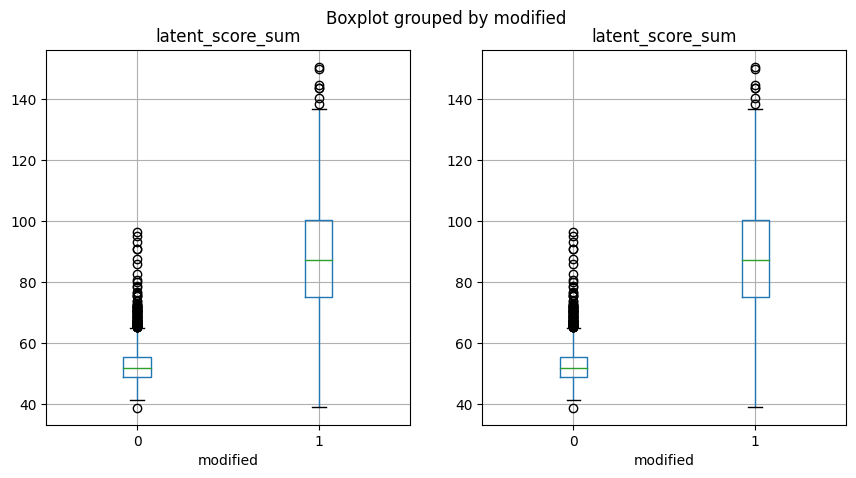

In [6]:
dataframe = latent_df
data = dataframe
# data = dataframe[dataframe['n']==4]
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=False)

data.boxplot('latent_score_sum','modified', ax=ax[0])
data.boxplot('latent_score_sum','modified', ax=ax[1])

print('Median 0: ', data[data['modified']==0].median())
print('IQR 0: ', data[data['modified']==0].quantile(0.75)-data[data['modified']==0].quantile(0.25))

print('Median 1: ', data[data['modified']==1].median())
print('IQR 1: ', data[data['modified']==1].quantile(0.75)-data[data['modified']==1].quantile(0.25))

In [ ]:
bleu_df = pd.read_csv('gdrive/Shareddrives/CS2952N/bleu_scores_flickr8k_other_images_50.csv')
meteor_df = pd.read_csv('gdrive/Shareddrives/CS2952N/meteor_scores_flickr8k_other_images_50.csv')
spice_df = pd.read_csv('gdrive/Shareddrives/CS2952N/spice_scores_flickr8k_other_images_50.csv')
cider_df = pd.read_csv('gdrive/Shareddrives/CS2952N/cider_scores_flickr8k_other_images_50.csv')